# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

Импорт необходимых библиотек

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [2]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\LicrimoVor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [4]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [5]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [6]:
from typing import TypedDict


class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


class BatchType(TypedDict):
	input_ids: torch.Tensor
	labels: torch.Tensor


def collate_fn_with_padding(
    input_batch: List[List[int]],
    pad_id=word2ind['<pad>'],
    max_len=256,
) -> BatchType:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        count_fill = max_seq_len - len(sequence['text'])
        sequence['text'] += [pad_id] * count_fill
        # for _ in range(max_seq_len - len(sequence['text'])):
        #     sequence['text'].append(pad_id)
        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(DEVICE)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(DEVICE)

    new_batch = {
        'input_ids': sequences,
        'labels': labels
    }

    return new_batch

In [7]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader[BatchType](
    train_dataset, shuffle=True,
    collate_fn=collate_fn_with_padding,
    batch_size=batch_size
)

eval_dataloader = DataLoader[BatchType](
    eval_dataset, shuffle=False,
    collate_fn=collate_fn_with_padding,
    batch_size=batch_size
)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [8]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['labels'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

In [9]:
from typing import TypedDict, Literal


class RecurrentSettings(TypedDict):
   """Внутренние настройки рекуррентного слоя."""
   dropout: float
   num_layers: int


type AggregationType = Literal['max', 'mean', 'last']
type RecurrentType = Literal['rnn', 'gru', 'lstm']
type CombineType = Literal['emb', 'rec', 'none']


class RecurrentProps(TypedDict):
	"""Пропсы для модели."""
	input_size: int
	hidden_size: int
	output_size: int
	aggregation_type: AggregationType
	recurent_type: RecurrentType
	combine_type: CombineType
	dropout_p: float
	settings_reccurent: RecurrentSettings
	count_fc: int


class FCBlock(nn.Module):

	def __init__(self, inp_size: int, out_size: int, dropout_p: float=0.15) -> None:
		super().__init__()
		self.act = nn.Tanh()
		self.linier = nn.Linear(inp_size, out_size)
		self.dropout = nn.Dropout(dropout_p)
	
	def forward(self, x):
		return self.act(self.dropout(self.linier(x)))


class RecurrentModel(nn.Module):
	"""Рекуреентная модель."""
	def __init__(
		self,
		input_size: int,
		hidden_size: int,
		output_size: int,
		aggregation_type: AggregationType,
		recurrent_type: RecurrentType,
		count_fc: int=1,
		combine_type: CombineType='none',
		dropout_p: float = 0.15,
		settings_recurrent: RecurrentSettings={},
	) -> None:
		super().__init__()
		self.embedding = nn.Embedding(input_size, hidden_size)
		match recurrent_type:
			case 'rnn':
				self.recurrent = nn.RNN(hidden_size, hidden_size, batch_first=True, **settings_recurrent)
			case 'gru':
				self.recurrent = nn.GRU(hidden_size, hidden_size, batch_first=True, **settings_recurrent)
			case 'lstm':
				self.recurrent = nn.LSTM(hidden_size, hidden_size, batch_first=True, **settings_recurrent)
			case _:
				raise ValueError('нет такой сети')
		linier_size = hidden_size * 2 if combine_type != 'none' else hidden_size
		self.liniers = nn.Sequential(
			nn.Tanh(),
			FCBlock(linier_size, hidden_size, dropout_p),
			*[FCBlock(hidden_size, hidden_size, dropout_p) for _ in range(count_fc-1)],
			nn.Linear(hidden_size, output_size)
		)
		self.recurrent_type: RecurrentType = recurrent_type
		self.aggregation_type: AggregationType = aggregation_type
		self.combine_type: CombineType = combine_type

	def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
		embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
		recurrent, _ = self.recurrent(embeddings)  # [batch_size, seq_len, hidden_dim]

		match self.aggregation_type:
			case 'max':
				output = recurrent.max(dim=1)[0] #[batch_size, hidden_dim]
			case 'mean':
				output = recurrent.mean(dim=1) #[batch_size, hidden_dim]
			case 'last':
				output = recurrent[:, -1, :]
			case _:
				raise ValueError("Invalid aggregation_type")

		match self.combine_type:
			case 'emb':
				output = torch.concat([output, embeddings[:, -1, :]], dim=1)
			case 'rec':
				output = torch.concat([output, recurrent[:, -1, :]], dim=1)
			case 'none':
				pass
			case _:
				raise ValueError("Invalid combine_type")

		prediction = self.liniers(output)
		return prediction

In [ ]:
from typing import Callable

from torch.optim import Optimizer, Adam


DEFAULT_SETTINGS: RecurrentProps = {
    'input_size': len(vocab),
	'hidden_size': 256,
    'output_size': 4,
	'aggregation_type': 'max',
    'dropout_p': 0.15,
	'combine_type': 'none',
	'count_fc': 1,
}

class History(TypedDict):
	train: list[float]
	eval: list[float]


class Experiment:
	"""Эксперимент - инкапсулирует данные по 1 серии изменений параметров модели."""
	model_types = ['rnn', 'gru', 'lstm']

	def __init__(
			self,
			changes: list[RecurrentProps],
			optimizer: type[Optimizer],
			name: str,
		) -> None:
		self.name = name
		self.changes = changes
		self.metrics: dict[str, float] = {key: 0.0 for key in self.model_types}
		self.results: dict[str, list[History]] = {key: [None] * len(changes) for key in self.model_types}
		self.models: dict[str, list[RecurrentModel]] = {key: [None] * len(changes) for key in self.model_types}

		self.__optimizer = optimizer


	def run(self, train: Callable[[RecurrentModel, Optimizer], History]):
		print(f"Run experiment: {self.name}")

		for model_type in self.model_types:
			for i in range(len(self.changes)):
				print(f"Train model: {model_type}#{i+1}")
				change = self.changes[i]
				settings = {**DEFAULT_SETTINGS, **change, 'recurrent_type': model_type}
				model = RecurrentModel(**settings)
				optimizer = self.__optimizer(model.parameters())
				history = train(model, optimizer)
				self.models[model_type][i] = model
				self.results[model_type][i] = history



experiments = [
	Experiment([{}], Adam, 'default'),
	Experiment([
		{'aggregation_type': 'mean'},
		{'aggregation_type': 'last'},
	], Adam, 'aggregation type'),
	Experiment([
		{'hidden_size': 128},
    	{'hidden_size': 512},
	], Adam, 'hidden size'),
	Experiment([
		{'dropout_p': 0},
		{'dropout_p': 0.1},
		{'dropout_p': 0.2},
	], Adam, 'dropout probability'),
	Experiment([
		{'settings_recurrent': {'dropout': 0.1, 'num_layers': 2}},
    	{'settings_recurrent': {'dropout': 0.15, 'num_layers': 2}},
	], Adam, 'dropout probability in recurrent layers'),
	Experiment([
		{'combine_type': 'emb'},
		{'combine_type': 'rec'},
	], Adam, 'concatenation embeddings'),
	Experiment([
		{'settings_recurrent': {'num_layers': 2}},
		{'settings_recurrent': {'num_layers': 3}},
		{'settings_recurrent': {'num_layers': 4}},
	], Adam, 'recurrent layers'),
	Experiment([
		{'count_fc': 2},
		{'count_fc': 3},
	], Adam, 'count full connected layres'),	
]

In [11]:
EPOCHS = 10


def train(model: RecurrentModel, optimizer: Optimizer) -> History:
	"""Алгоритм обучения модели."""
	model.to(DEVICE)
	criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
	history: History = {'eval': [], 'train': []}
	for epoch in range(EPOCHS):
		print(f"Epoch: {epoch+1}")
		losses = []
		model.train()
		for batch in tqdm(train_dataloader):
			optimizer.zero_grad()
			logits = model(batch['input_ids'])
			loss = criterion(logits, batch['labels'])
			loss.backward()
			optimizer.step()
			losses.append(loss.item())

		model.eval()
		with torch.no_grad():
			acc = evaluate(model, eval_dataloader)
			history['eval'].append(acc)
		history['train'].append(sum(losses) / len(losses))

	return history

In [12]:
for experiment in experiments[:4]:
    experiment.run(train)

Run experiment: default
Train model: rnn#1
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: gru#1
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: lstm#1
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Run experiment: aggregation type
Train model: rnn#1
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: rnn#2
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: gru#1
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: gru#2
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: lstm#1
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: lstm#2
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Run experiment: hidden size
Train model: rnn#1
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: rnn#2
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: gru#1
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: gru#2
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: lstm#1
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: lstm#2
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Run experiment: dropout probability
Train model: rnn#1
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: rnn#2
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: rnn#3
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: gru#1
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: gru#2
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: gru#3
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: lstm#1
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: lstm#2
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: lstm#3
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

In [24]:
for experiment in experiments[4:]:
    print(experiment)
    experiment.run(train)

Run experiment: dropout probability in recurrent layers
Train model: rnn#1
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: rnn#2
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: gru#1
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: gru#2
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: lstm#1
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: lstm#2
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Run experiment: concatenation embeddings
Train model: rnn#1
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: rnn#2
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: gru#1
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: gru#2
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: lstm#1
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: lstm#2
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Run experiment: recurrent layers
Train model: rnn#1
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: rnn#2
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: rnn#3
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: gru#1
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: gru#2
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: gru#3
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: lstm#1
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: lstm#2
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: lstm#3
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Run experiment: count full connected layres
Train model: rnn#1
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: rnn#2
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: gru#1
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: gru#2
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: lstm#1
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

Train model: lstm#2
Epoch: 1


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3750 [00:00<?, ?it/s]

C:\Users\LicrimoVor\AppData\Local\Temp\ipykernel_13672\1388516471.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


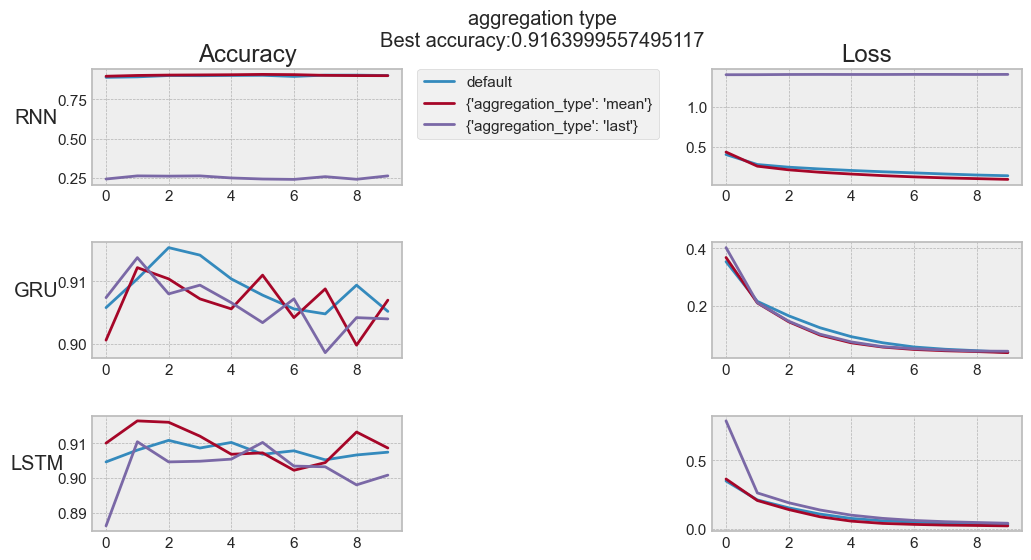

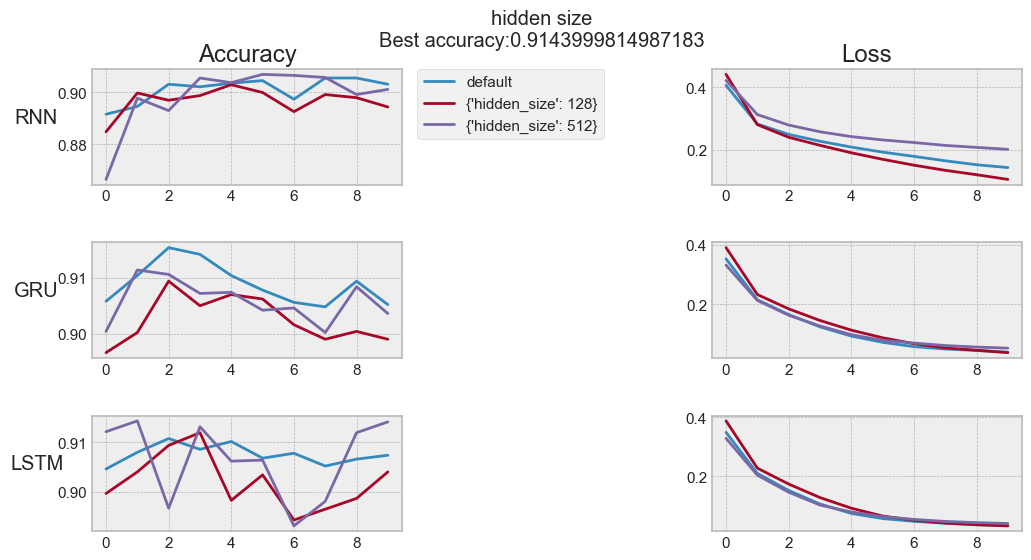

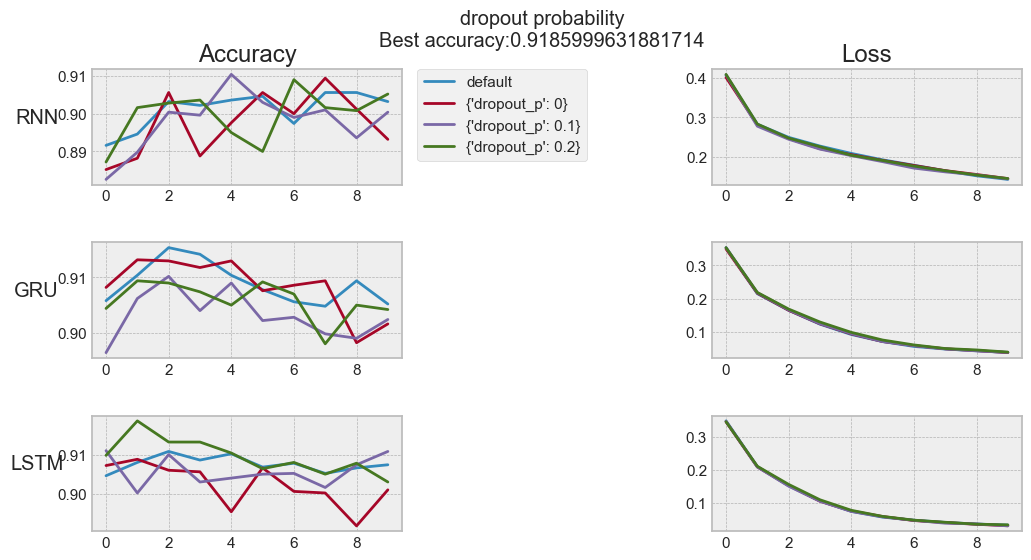

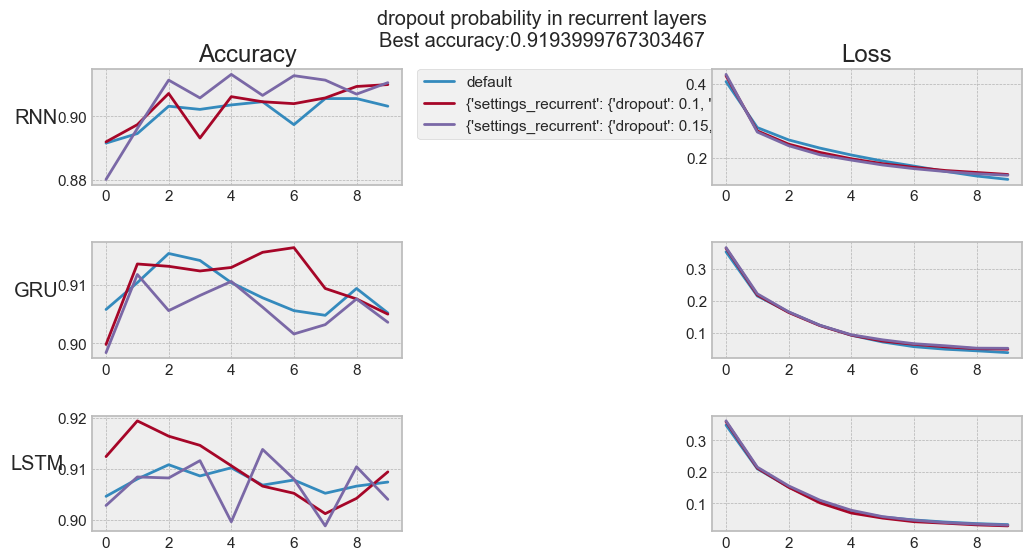

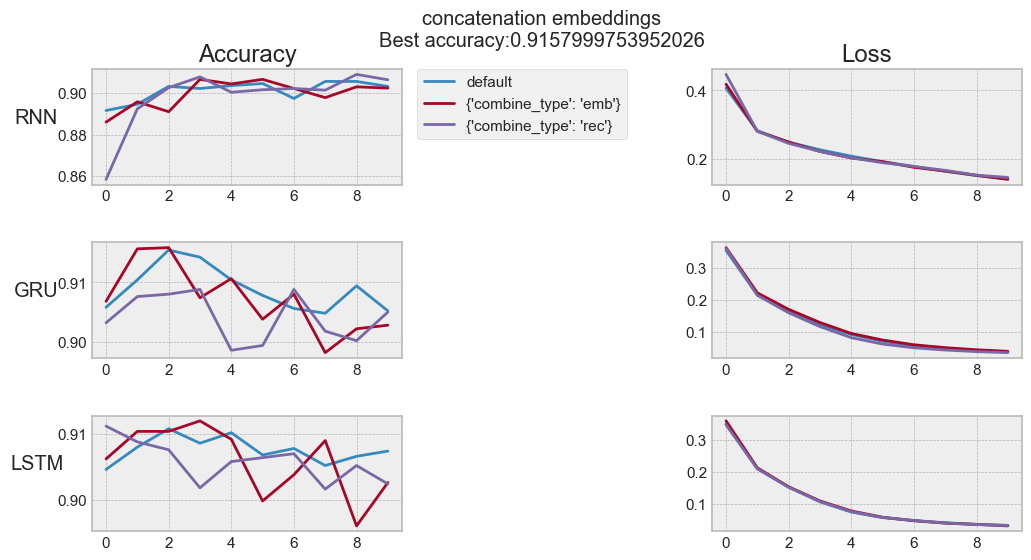

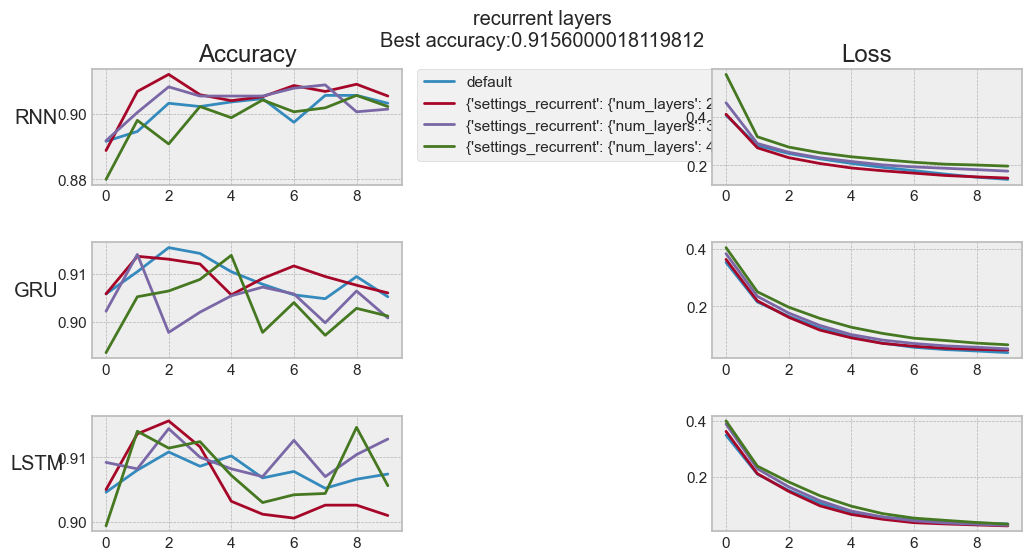

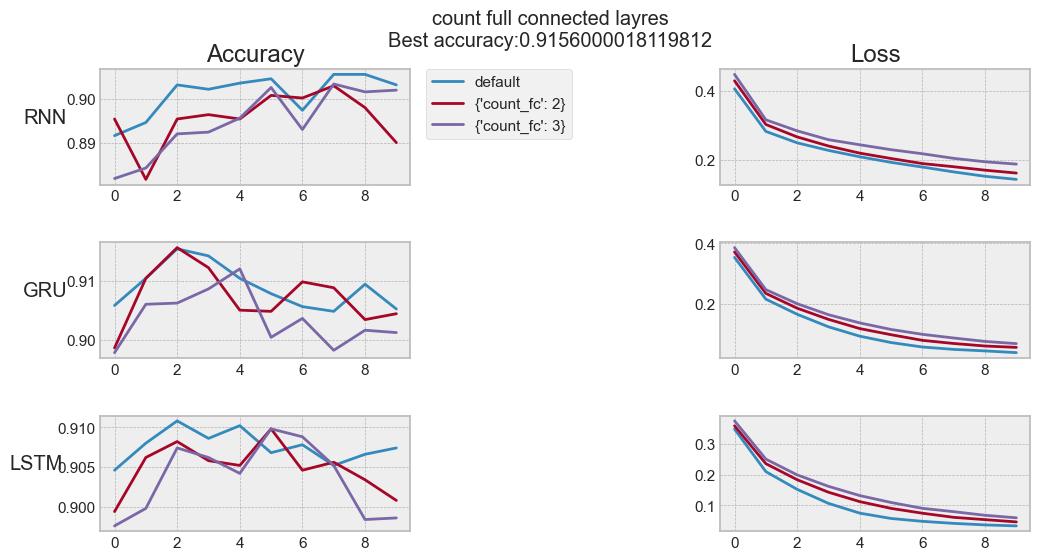

In [58]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

plt.style.use('bmh')

default = experiments[0]

for experiment in experiments[1:]:
	axs: list[list[Axes]]
	fig, axs = plt.subplots(len(experiment.model_types), 2)
	
	fig.set_figwidth(12)
	fig.set_figheight(len(experiment.model_types)*2)
	fig.subplots_adjust(wspace=1, hspace=0.5)

	# titles
	axs[0][0].set_title('Accuracy')
	axs[0][1].set_title('Loss')

	best_acc = 0
	# default
	for i, model_type in enumerate(experiment.model_types):
		axs[i][0].set_ylabel(model_type.upper(), labelpad=15, rotation=0, size='large')
		loss = default.results[model_type][0]['train']
		acc = default.results[model_type][0]['eval']
		axs[i][0].plot(acc, label='default')
		axs[i][1].plot(loss, label='default')

	for j, change in enumerate(experiment.changes):
		for i, model_type in enumerate(experiment.model_types):
			loss = experiment.results[model_type][j]['train']
			acc = experiment.results[model_type][j]['eval']
			best_acc = max(acc) if max(acc) > best_acc else best_acc

			axs[i][0].plot(acc, label=str(change))
			axs[i][1].plot(loss, label=str(change))
	axs[0][0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
	fig.suptitle(f'{experiment.name}\nBest accuracy:{best_acc}')
	fig.show()

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

----

Вывод:
- Тип агрегации - `максимум` показал лучший результат на GRU и RNN, на LSTM хорошо себя показало среднее. Если вообще убрать агрегацию и поставлять только последний слой, то RNN вообще не обучается.
- Размер скрытого слоя - 256 оказался самым оптимальным выбором. LSTM начало разносить, думаю нужно было уменьшить lr (мб чувствительнее, чем остальные)
- Слой Dropout - при увеличении вероятности GRU и LSTM становятся более стабильными при обучении
- Слой Dropout (в реккуретных слоях) - положительно сказывается на всех моделях. Оптимальное значение - 0.1
- Конкатенация - для GRU и LSTM привнесла свои колебания и не улучшила результат. Для RNN любая конкатенация дала хороший результат
- Рекуррентные слои - большое количество слоев пагубно сказывается на результат модели (мб эффект переобучения). Оптимальное значение 2
- FC слои - при повышении количества полносвязаных слоев качество модели падает. Мб для повышения количества FC слоев нужно увеличивать кол-во рекуррентные слоев 


Лучшая модель показала accuracy 0.919

----